In [230]:
import pandas
import os
#import graphviz

In [231]:
traindf=pandas.read_csv('train.csv')

testdf=pandas.merge(pandas.read_csv( 'test.csv'),
                    pandas.read_csv('gender_submission.csv'),
                    on="PassengerId")

In [232]:
traindf.var()

PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              211.019125
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

In [233]:
for k in traindf.keys():
    print('{0}: {1}'.format(k, len(traindf[k].unique())))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 89
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 148
Embarked: 4


In [234]:
for k in traindf.keys():
    if len(traindf[k].unique())<=15:
        print(k)

Survived
Pclass
Sex
SibSp
Parch
Embarked


In [235]:
import math

def forAge(row):
    if row['Age'] < 10:
        return '<10'
    elif math.isnan(row['Age']):
        return "nan"
    else:
        dec = str(int(row['Age']/10))
        return "{0}0's".format(dec)

decade=traindf.apply(forAge, axis=1)
print("decade: {1}".format(k, len(decade.unique())))

decade: 10


In [236]:
import math
def pretreat(df):
    # create a df with discrete variables (len<10)
    lvd=[k for k in df.keys() if len(df[k].unique())<=15]
    res=df[lvd].copy()
    
    forAge = lambda row: "{0}".format(int(row['Age']/10)) if not math.isnan(row['Age']) else str("nan")
    res['Decade']=df.apply(forAge, axis=1)
   
    return res

In [237]:
ptraindf=pretreat(traindf)
ptestdf=pretreat(testdf)

In [239]:
ptraindf.to_csv( 'post_train.csv', index=False)
ptestdf.to_csv( 'post_test.csv', index=False)

In [240]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [241]:
df = pandas.read_csv('post_train.csv')
for k in df.keys():
    print("{} : {}".format(k, df[k].unique()))

Survived : [0 1]
Pclass : [3 1 2]
Sex : ['male' 'female']
SibSp : [1 0 3 4 2 5 8]
Parch : [0 1 2 5 3 4 6]
Embarked : ['S' 'C' 'Q' nan]
Decade : [ 2.  3. nan  5.  0.  1.  4.  6.  7.  8.]


In [258]:
template=gum.BayesNet()
template.add(gum.RangeVariable("Survived", "Survived",0,1))
template.add(gum.RangeVariable("Pclass", "Pclass",1,3))
template.add(gum.LabelizedVariable("Sex", "Sex",0).addLabel("female").addLabel("male"))
template.add(gum.RangeVariable("SibSp", "SibSp",0,8))
template.add(gum.RangeVariable("Parch", "Parch",0,9))
template.add(gum.LabelizedVariable("Embarked", "Embarked",0).addLabel('').addLabel('C').addLabel('Q').addLabel('S'))
#template.add(gum.LabelizedVariable("Decade", "Decade", 0).addLabel('').addLabel('00th').addLabel('10th').addLabel('20th').addLabel('30th').addLabel('40th').addLabel('50th').addLabel('60th').addLabel('70th').addLabel('80th'))
#template.add(gum.LabelizedVariable("Decade", "Calculated decade", 10).addLabel(''))
gnb.showBN(template)

In [259]:
learner = gum.BNLearner('post_train.csv', template )
bn = learner.learnBN()
bn

(gum::BayesNet<double>@000002982C05E090) BN{nodes: 6, arcs: 7, domainSize: 4320, parameters: 238, compression ratio: 94% }

In [260]:
gnb.showInformation(bn,{},size="20")

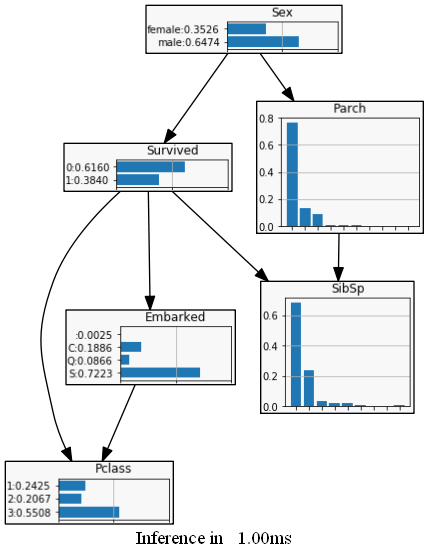

In [261]:
gnb.showInference(bn)

In [262]:
gnb.sideBySide(bn, gum.MarkovBlanket(bn, 'Survived'), captions=["Learned Bayesian Network", "Markov blanket of 'Survived'"])

Learned Bayesian Network,Markov blanket of 'Survived'


 res\titanic\post_train.csv : [ ############################################## ] 100%
 result in res\titanic\post_train.csv-ROC_unnamed-Survived-1.png


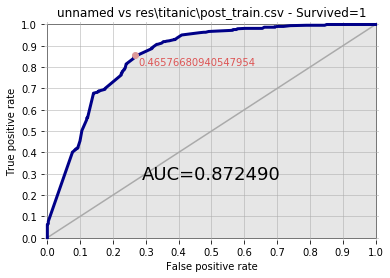

In [263]:
from pyAgrum.lib.bn2roc import showROC

showROC(bn, os.path.join('res', 'titanic', 'post_train.csv'),'Survived',"1",True,True)

In [264]:
vars = [ var for var in ptestdf.keys() if var != "Survived" ]
ie=gum.LazyPropagation(bn)
testdf=pandas.read_csv(os.path.join('res', 'titanic', 'post_test.csv'))

def init_belief():
    # Initialize evidence
    for var in vars:
        ie.addEvidence(var, 0)

def update_beliefs(row):
    # Update beliefs from a given row less the Survived variable
    for var in vars:
        label = str(row.to_dict()[var])
        idx = bn.variable(var).index(str(row.to_dict()[var]))
        ie.chgEvidence(var, idx)
    ie.makeInference()
    
def is_well_predicted(row):
    update_beliefs(row)
    marginal = ie.posterior('Survived')
    outcome = row.to_dict()['Survived']
    if outcome == 0: # Did not survived
        if marginal.toarray()[1] < 0.46576680:
            return "True Positive"
        else:
            return "False Negative"
    else: # Survived
        if marginal.toarray()[1] >= 0.46576680:
            return "True Negative"
        else:
            return "False Positive"

init_belief()
ie.addTarget('Survived')

result = testdf.apply(is_well_predicted, axis=1)

result.value_counts(True)

NotFound: [pyAgrum] Object not found: hashtable's chained list contains no element with this key <Decade>

In [265]:
positives=result.select(lambda idx: result[idx].startswith("True")).count()
total=result.count()

print("{0:.2f}% good predictions".format(positives/total*100))

94.02% good predictions


C:\Users\SUIC_STAR\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.
